In [69]:
import pandas as pd
import easygui as eg
import numpy as np
import seaborn as sns
import matplotlib as plt
from scipy.optimize import curve_fit
from scipy.stats import ttest_ind
from ppi_analysis import *

In [70]:
data_file = '/home/roshan/Dropbox/Harmonia/Aphrodite/Experiments/PPI_Project/LDF74_Run_Results.txt'
#data_file = eg.fileopenbox(filetypes=['txt','csv'],msg='Select Data File to load')

In [71]:
header= {0:'Chamber',1:'Subject',2:'Session',
         3:'Channel',4:'Trial',5:'Trial Num',
         6:'Group',7:'Param',8:'Trial List Block',
         9:'Samples',10:'Rate',11:'V Start',12:'mV Max',
         13:'T Max',14:'mv Avg',15:'V Peak',16:'T Peak',
         17:'Run Time',18:'TimeStamp',19:'Run Data'}

In [72]:
data = import_ppi_data(data_file)
data = data.dropna()

In [73]:
# Parse Session and Trial into Date, Animal, Session_Type, Trial_Type, Stim DB, Prepulse DB
data = pd.concat((data,data.Session.str.split('_', expand=True)), axis=1).rename(columns={0:'Date',1:'Animal',2:'Session_Type'})
data = pd.concat((data,data.Trial.str.split('_',expand=True)),axis=1).rename(columns={0:'Trial_Type',1:'Stim_dB',2:'Prepulse_dB'})
cols = ['Stim_dB','Prepulse_dB']
data[cols] = data[cols].apply(pd.to_numeric)
animal = data['Subject'].unique()[0]
#data.head()

In [74]:
# Grab ASR data 
asrData = data.query('Session_Type=="ASR"')

In [75]:
def logfunc(x,a,b):
    #y = a/(1+np.exp(-b*(x-c)))
    y = a+b*np.log(x)
    return y

In [76]:
def calcPPI(row,df):
   # print(row)
    if row['Trial_Type']=='PPI':
        stimDB = row['Stim_dB']
        stimMean = df.query('Trial_Type=="Startle" & Stim_dB==@stimDB')['mV Max'].mean()
        return 100*(1-row['mV Max']/stimMean)
    else:
        return row['% PPI']

In [77]:
custom_style = {'figure.facecolor':'.8',
                "axes.facecolor":".8",
                'axes.edgecolor':'.8',
                "axes.labelcolor":"black",
                "axes.grid":True,
                'grid.color':'black',
                "text.color":"black",
                "patch_edgecolor":'black',
                "xtick.color":"black",
                "ytick.color":"black",
                'axes.edgecolor':'black'}
sns.set_style('whitegrid',rc=custom_style)
sns.set_context('talk')
col_palette = sns.color_palette("bright")

In [78]:
ppiData = data.query('Session_Type=="rPPI"')

In [79]:
#startleDB = ppiData.query('Trial_Type=="Startle"')['Stim_dB'].unique()
ppiData.loc[:,"% PPI"] = np.nan
ppiData.loc[:,'% PPI'] = ppiData.apply(lambda x: calcPPI(x,ppiData),axis=1)

In [63]:
def ppi_mets(x):
    d = {}
    d['Mean Startle (mV)'] = x['mV Max'].mean()
    d['Startle SD (mV)'] = x['mV Max'].std()
    d['Mean PPI (%)'] = x['% PPI'].mean()
    d['PPI SD (%)'] = x['% PPI'].std()
    return pd.Series(d,index=['Mean Startle (mV)','Startle SD (mV)','Mean PPI (%)','PPI SD (%)'])
ppi_metrics = ppiData.groupby(['Trial_Type','Stim_dB','Prepulse_dB']).apply(ppi_mets).round(2)

In [232]:
# Order bars
a = ppiData['Trial'].unique()
sortDF = pd.DataFrame(a,columns=['Trial'])
sortDF = pd.concat((sortDF,sortDF.Trial.str.split('_',expand=True)),axis=1).rename(columns={0:'Trial_Type',1:'Stim_dB',2:'Prepulse_dB'})
cols = ['Stim_dB','Prepulse_dB']
sortDF[cols] = sortDF[cols].apply(pd.to_numeric)
sortDF['Trial_Type'] = pd.Categorical(sortDF['Trial_Type'],['NoStim','PPIO','Startle','PPI'])
sortDF = sortDF.sort_values(by=['Trial_Type','Stim_dB','Prepulse_dB'])
sortDF.reset_index(inplace=True,drop=True)
sortDF.reset_index(inplace=True)
sortDF.rename(columns={'index':'x'},inplace=True)
barOrder = sortDF['Trial']

In [235]:
# Stats: Welch's T-test between PPI Trials and Startle Trials
# Get stim and prepulse DB values, figure out which prepulse trials have corresponding startle trials
ppiStim = ppiData.query("Trial_Type=='PPI'")['Stim_dB'].unique()
stimDB = [x for x in ppiStim if not ppiData.query('Trial_Type=="Startle" and Stim_dB==@x').empty]
ppDB = ppiData.query('Trial_Type=="PPI"')['Prepulse_dB'].unique()
ppiStats = pd.DataFrame(columns=['Stim_dB','Prepulse_dB','T-statistic','p-Value','sigstars','x'])
for stim in stimDB:
    for pp in ppDB:
        a = ppiData.query('Trial_Type=="Startle" and Stim_dB==@stim')['mV Max']
        b = ppiData.query('Trial_Type=="PPI" and Stim_dB==@stim and Prepulse_dB==@pp')['mV Max']
        if a.empty or b.empty:
            continue
        res = ttest_ind(a,b,equal_var=False)
        ss = ''
        if res.pvalue<=0.05:
            ss = '*'
        if res.pvalue<=0.01:
            ss = '**'
        if res.pvalue<=0.001:
            ss='***'
        x = sortDF.query('Stim_dB==@stim and Prepulse_dB==@pp')['x'].tolist()[0]
        ppiStats.loc[-1] = [stim,pp,res.statistic,res.pvalue,ss,x]
        ppiStats.reset_index(drop=True,inplace=True)

[Text(0, 0.5, '% PPI'), Text(0.5, 0, 'Prepulse dB')]

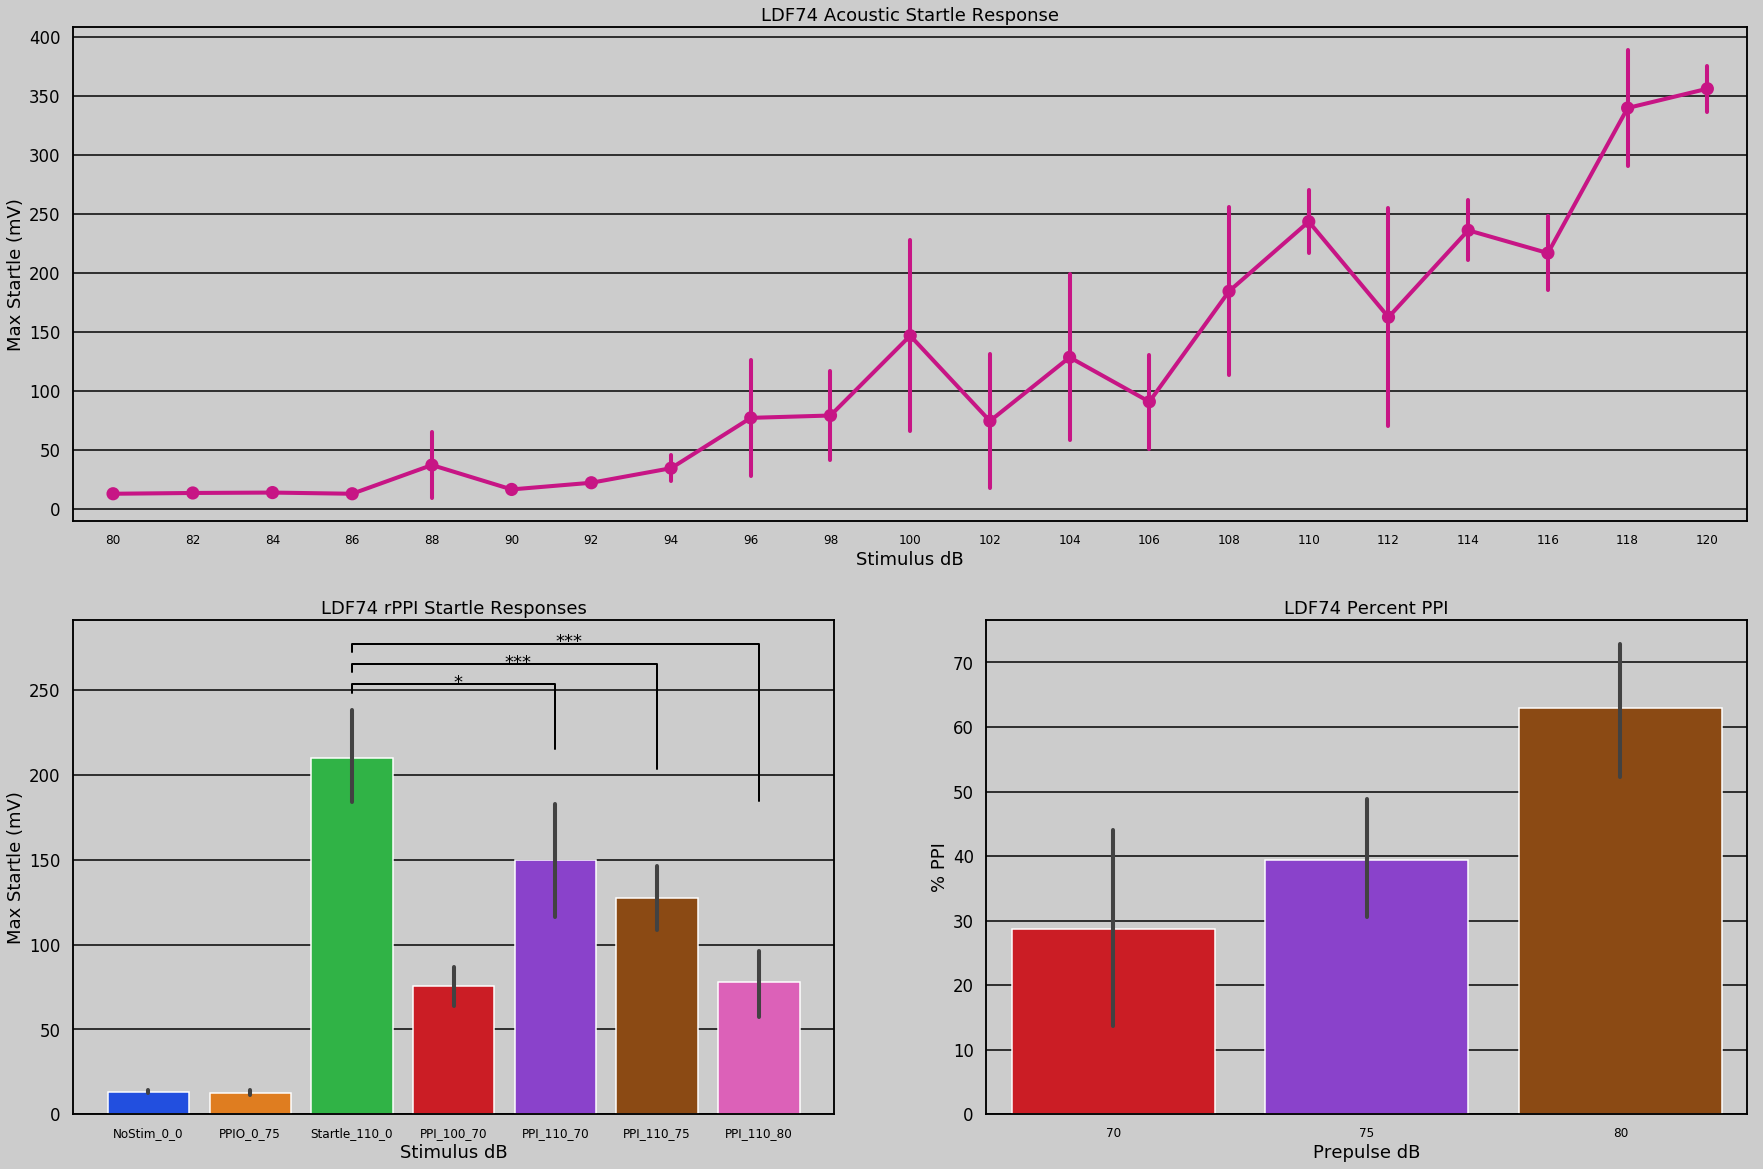

In [255]:
pal = sns.color_palette('bright')
plt.rcParams["figure.figsize"] = (30, 20)
plt.rcParams["xtick.labelsize"] = 12
ax = plt.pyplot.subplot(2,1,1)
g = sns.pointplot(ax=ax,x="Stim_dB",y='mV Max',data=asrData,color='mediumvioletred',ci='sd')
g.set_title(animal+' Acoustic Startle Response')
g.set(xlabel='Stimulus dB',ylabel='Max Startle (mV)')

ax = plt.pyplot.subplot(2,2,3)
g = sns.barplot(ax=ax,x='Trial',y='mV Max',data=ppiData,palette='bright',order=barOrder)
g.set_title(animal+' rPPI Startle Responses')
g.set(xlabel='Stimulus dB',ylabel='Max Startle (mV)')
ylim = g.get_ylim()
errorbars = g.get_lines()
barTops = [x.get_ydata()[1] for x in errorbars]
startX = sortDF.x[sortDF.Trial_Type=='Startle'].tolist()[0]
endX = ppiStats.x[ppiStats['p-Value']<=0.05].tolist()
stars = ppiStats.sigstars[ppiStats['p-Value']<=0.05].tolist()
startY = barTops[startX]+10
endY = [barTops[x] for x in endX]
for x,y,ss in zip(endX,endY,stars):
    midpoint = (x+startX)/2
    midY = (startY+y)/2
    plt.pyplot.plot([startX,startX,x,x],[startY,startY+5,startY+5,midY],linewidth=2,color='k')
    plt.pyplot.text(midpoint,startY+3,ss)
    startY = startY+12

ax=plt.pyplot.subplot(2,2,4)
g=sns.barplot(ax = ax,x='Prepulse_dB',y="% PPI",data=ppiData,order = [70,75,80],palette=pal[3:6])
g.set_title(animal+' Percent PPI')
g.set(xlabel='Prepulse dB',ylabel='% PPI')

#plt.pyplot.savefig(animal+'_PPI_Results_Figure.png')

In [39]:
ppiData.groupby('Trial').count()

,Chamber,Subject,Session,Channel,Trial Num,Group,Trial List Block,Samples,Rate,V Start,...,T Peak,Run Time,TimeStamp,Date,Animal,Session_Type,Trial_Type,Stim_dB,Prepulse_dB,% PPI
Trial,,,,,,,,,,,,,,,,,,,,,
NoStim_0_0,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,0
PPIO_0_75,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,0
PPI_100_70,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,0
PPI_110_70,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
PPI_110_75,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
PPI_110_80,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
Startle_110_0,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,0


In [40]:
# Also make & output table of trial counts for each session
# Validate animal names
# Check how many nans are dropped

In [41]:
a = data.groupby(['Session_Type','Trial_Type','Stim_dB','Prepulse_dB']).size()#.reset_index(name='counts')
print(a)

Session_Type  Trial_Type  Stim_dB  Prepulse_dB
ACC           NoStim      0        0               5
ACC2          NoStim      0        0               4
ASR           Startle     80       0               3
                          82       0               3
                          84       0               3
                          86       0               3
                          88       0               3
                          90       0               3
                          92       0               3
                          94       0               3
                          96       0               3
                          98       0               3
                          100      0               3
                          102      0               3
                          104      0               3
                          106      0               3
                          108      0               3
                          110      0               3

In [43]:
print('Loaded data for '+animal+'\n\nTrial Counts\n---------------')
print(a.to_frame().rename(columns={0:'Counts'}))

Loaded data for LDF74

Trial Counts
---------------
                                             Counts
Session_Type Trial_Type Stim_dB Prepulse_dB        
ACC          NoStim     0       0                 5
ACC2         NoStim     0       0                 4
ASR          Startle    80      0                 3
                        82      0                 3
                        84      0                 3
                        86      0                 3
                        88      0                 3
                        90      0                 3
                        92      0                 3
                        94      0                 3
                        96      0                 3
                        98      0                 3
                        100     0                 3
                        102     0                 3
                        104     0                 3
                        106     0                 3
            

In [19]:
#ppi_metrics = ppi_metrics.to_frame()
print ('\n\nPPI Metrics\n------------\n')
print(ppi_metrics)



PPI Metrics
------------

                                Mean Startle (mV)  Startle SD (mV)  \
Trial_Type Stim_dB Prepulse_dB                                       
NoStim     0       0                        13.30             4.06   
PPI        112     70                      294.17            88.42   
                   75                      200.75            95.01   
                   80                      138.83            48.56   
PPIO       0       75                       13.86             3.48   
Startle    112     0                       385.94           125.91   

                                Mean PPI (%)  PPI SD (%)  
Trial_Type Stim_dB Prepulse_dB                            
NoStim     0       0                     NaN         NaN  
PPI        112     70                  23.78       22.91  
                   75                  47.98       24.62  
                   80                  64.03       12.58  
PPIO       0       75                    NaN         NaN 

In [28]:
a = ppiData.query('Trial_Type=="PPI" and Prepulse_dB==70')['mV Max']
stimDB = 112
b = ppiData.query('Trial_Type=="Startle" and Stim_dB==@stimDB')['mV Max']

In [30]:
res = ttest_ind(a,b,equal_var=False)

In [32]:
res.statistic

-2.26454811130568

In [45]:
stimDB = ppiData.query('Trial_Type=="Startle"')['Stim_dB'].unique()


In [44]:
stimDB

array([112])

In [46]:
ppDB

array([70, 75, 80])

In [155]:
print(ppiStats)
print(sortDF)

  Stim_dB Prepulse_dB  T-statistic       p-Value sigstars
0     110          70     2.624339  1.569130e-02        *
1     110          75     4.689398  8.846888e-05      ***
2     110          80     7.229531  1.211713e-07      ***
           Trial Trial_Type Stim_dB Prepulse_dB
0     NoStim_0_0     NoStim       0           0
5      PPIO_0_75       PPIO       0          75
6  Startle_110_0    Startle     110           0
1     PPI_100_70        PPI     100          70
2     PPI_110_70        PPI     110          70
3     PPI_110_75        PPI     110          75
4     PPI_110_80        PPI     110          80


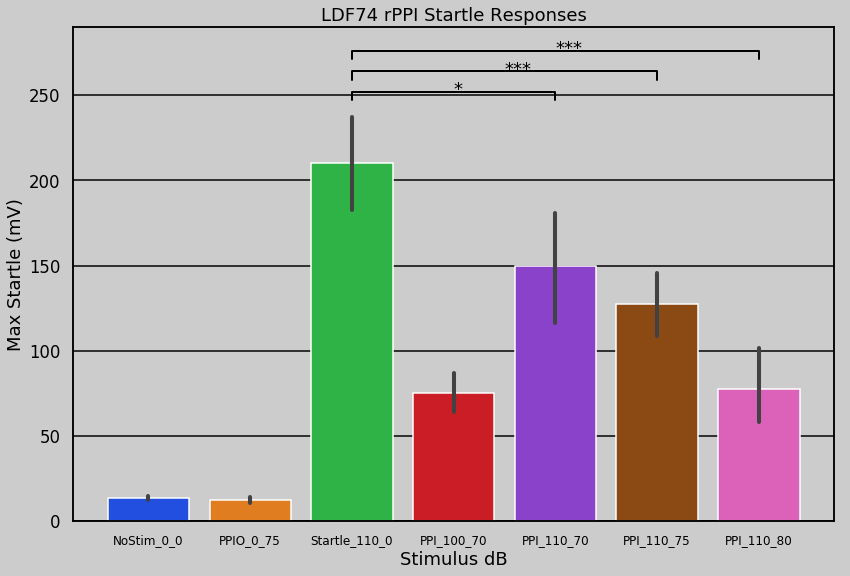

In [253]:
ax = plt.pyplot.subplot(2,2,3)
g = sns.barplot(ax=ax,x='Trial',y='mV Max',data=ppiData,palette='bright',order=barOrder)
g.set_title(animal+' rPPI Startle Responses')
g.set(xlabel='Stimulus dB',ylabel='Max Startle (mV)')
ylim = g.get_ylim()
errorbars = g.get_lines()
barTops = [x.get_ydata()[1] for x in errorbars]
startX = sortDF.x[sortDF.Trial_Type=='Startle'].tolist()[0]
endX = ppiStats.x[ppiStats['p-Value']<=0.05].tolist()
stars = ppiStats.sigstars[ppiStats['p-Value']<=0.05].tolist()
startY = barTops[startX]+10
endY = [barTops[x] for x in endX]
for x,ss in zip(endX,stars):
    midpoint = (x+startX)/2
    plt.pyplot.plot([startX,startX,x,x],[startY,startY+5,startY+5,startY],linewidth=2,color='k')
    plt.pyplot.text(midpoint,startY+3,ss)
    startY = startY+12

In [154]:
g.axes.get_ylim()

(0.0, 249.19289062499996)